<a href="https://colab.research.google.com/github/cristianmunoz1/Intro_ML_project/blob/main/Clasificaci%C3%B3n/03_Modelo_KNN_Regresion_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KNN para clasificación
Aplicamos un modelo no paramétrico KNN (para clasificación) con el objetivo de predecir si una mascota es adoptada o no.

Importes necesarios

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import (
  precision_score, recall_score,
  roc_auc_score, accuracy_score,
  confusion_matrix, ConfusionMatrixDisplay,
  roc_curve
)

# Segunda parte
from sklearn.model_selection import GridSearchCV

Leemos los datos. Recuerda tener el archivo 'data.csv' cargado en tu entorno de trabajo.


Distribución de la variable objetivo (AdoptionLikelihood):
AdoptionLikelihood
0    0.671649
1    0.328351
Name: proportion, dtype: float64


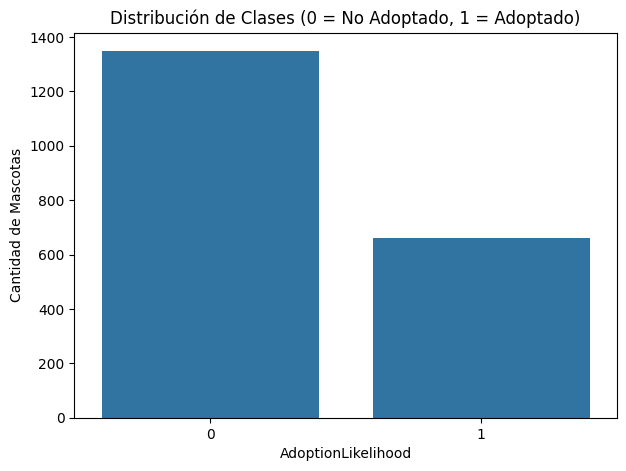

In [2]:
data = pd.read_csv('data_class.csv')
print("\nDistribución de la variable objetivo (AdoptionLikelihood):")
print(data['AdoptionLikelihood'].value_counts(normalize=True))
plt.figure(figsize=(7, 5))
sns.countplot(x='AdoptionLikelihood', data=data)
plt.title('Distribución de Clases (0 = No Adoptado, 1 = Adoptado)')
plt.ylabel('Cantidad de Mascotas')
plt.show()

Partimos los datos en x e y. También lo partimos en train y en test.

In [3]:
X = data.drop(columns=['AdoptionLikelihood'])
y = data['AdoptionLikelihood'].astype(int)

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Tamaño del conjunto de entrenamiento: {X_train_final.shape}")
print(f"Tamaño del conjunto de prueba: {X_test_final.shape}")

Tamaño del conjunto de entrenamiento: (1605, 22)
Tamaño del conjunto de prueba: (402, 22)


## Primera parte
Entrenamiento de knn manual y búsqueda de mejores parámetros manual

Definimos los ks que usaremos para escoger el más óptimo


In [4]:
ks = range(3, 26, 2)
resultados_cv = []

Definimos la función que implementa una regresión con KNN pasándole los datos de train, el k y las muestras de test.

In [5]:

resultados_cv = []
ks = range(3, 26, 2)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Iniciando Validación Cruzada Estratificada para encontrar el mejor k...")
for k in ks:
    roc_auc_scores_fold = []

    for train_index, val_index in skf.split(X_train_final, y_train_final):
        X_tr, X_val = X_train_final.iloc[train_index], X_train_final.iloc[val_index]
        y_tr, y_val = y_train_final.iloc[train_index], y_train_final.iloc[val_index]


        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_tr, y_tr)

        y_val_proba = model.predict_proba(X_val)[:, 1]
        roc_auc = roc_auc_score(y_val, y_val_proba)
        roc_auc_scores_fold.append(roc_auc)

    resultados_cv.append({
        'k': k,
        'mean_roc_auc': np.mean(roc_auc_scores_fold),
        'std_roc_auc': np.std(roc_auc_scores_fold)
    })

resultados_df = pd.DataFrame(resultados_cv)

print("\nResultados de la validación cruzada:")
print(resultados_df)

Iniciando Validación Cruzada Estratificada para encontrar el mejor k...

Resultados de la validación cruzada:
     k  mean_roc_auc  std_roc_auc
0    3      0.697868     0.036962
1    5      0.716851     0.037329
2    7      0.721800     0.031895
3    9      0.714097     0.030471
4   11      0.713471     0.033796
5   13      0.713187     0.034048
6   15      0.717536     0.030310
7   17      0.725669     0.029163
8   19      0.725378     0.027457
9   21      0.722346     0.030123
10  23      0.722257     0.032247
11  25      0.721487     0.027797


Expermientamos con diferentes valores de k

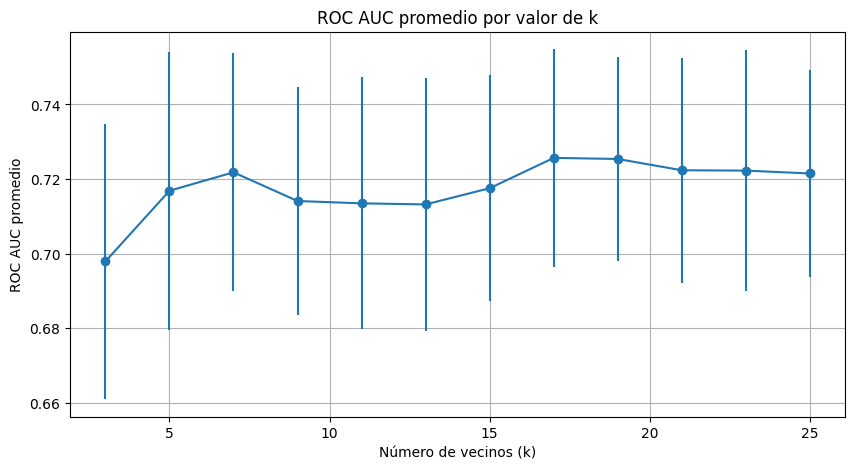

In [6]:
plt.figure(figsize=(10, 5))
plt.errorbar(resultados_df['k'], resultados_df['mean_roc_auc'], yerr=resultados_df['std_roc_auc'], fmt='-o')
plt.title('ROC AUC promedio por valor de k')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('ROC AUC promedio')
plt.grid()
plt.show()

In [7]:
mejor_k = resultados_df.loc[resultados_df['mean_roc_auc'].idxmax(), 'k']
print(f"\nMejor k encontrado: {mejor_k}")


Mejor k encontrado: 17


In [8]:
modelo_knn = KNeighborsClassifier(n_neighbors=mejor_k)
modelo_knn.fit(X_train_final, y_train_final)

# Predicción en conjunto de prueba
y_pred = modelo_knn.predict(X_test_final)
y_proba = modelo_knn.predict_proba(X_test_final)[:, 1]

In [9]:
print("\n=== Métricas en el conjunto de prueba ===")
print(f"Precisión: {precision_score(y_test_final, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test_final, y_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test_final, y_proba):.3f}")


=== Métricas en el conjunto de prueba ===
Precisión: 0.583
Recall:    0.371
ROC AUC:   0.692


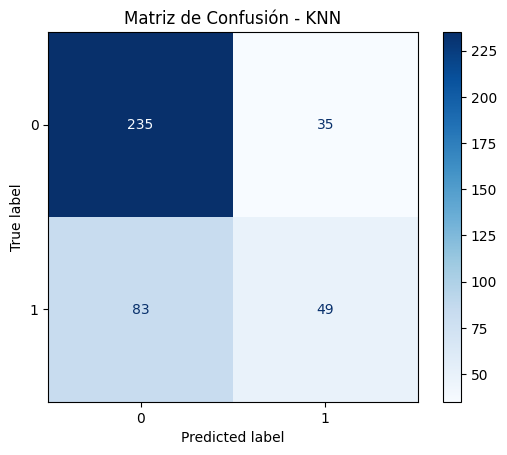

In [10]:
ConfusionMatrixDisplay.from_estimator(modelo_knn, X_test_final, y_test_final, cmap='Blues')
plt.title("Matriz de Confusión - KNN")
plt.show()


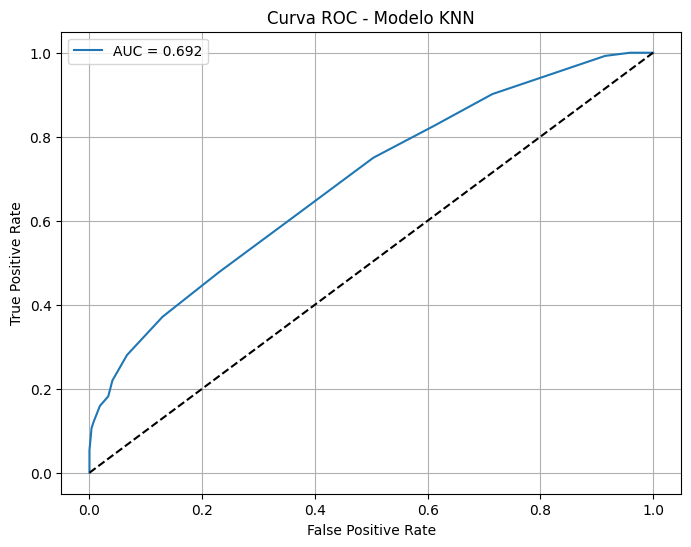

In [11]:
fpr, tpr, _ = roc_curve(y_test_final, y_proba)
auc = roc_auc_score(y_test_final, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo KNN')
plt.legend()
plt.grid()
plt.show()


## Segunda parte
Entrenamiento de KNN y búsqueda de parámetros con RandomizedSearchCV


En este caso, usaremos métodos ya implementados por Scikitlearn para comparar los resultados.

Definimos el modelo a usar.

In [12]:
knn = KNeighborsClassifier()

Definimos la malla de hiperparámetros para evaluar

In [13]:
param_grid = {
    # Verificamos desde 1 hasta 30 vecinos.
    'n_neighbors': list(range(1, 31)),
    # Verificamos si usamos la medida de distancia también como peso para la influencia de los vecinos
    'weights': ['uniform', 'distance'],
    # Verificamos los tipos de distancias
    'metric': ['euclidean', 'manhattan'],
}

Definimos el objeto de cross-validation. Es estratificado por el desbalance que hay entre las clases

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Definimos el objeto GridSearchCV

In [15]:
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

Empezamos la búsqueda de los mejores parámetros del modelo

In [16]:
grid_search.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=1)

In [17]:
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor puntuación ROC AUC:", grid_search.best_score_)

Mejores hiperparámetros encontrados: {'metric': 'manhattan', 'n_neighbors': 26, 'weights': 'distance'}
Mejor puntuación ROC AUC: 0.7441941180613113


### Entrenamiento del modelo con los mejores hiperparámetros

In [18]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=26, weights='distance')

Entrenamiento del modelo

In [19]:
knn.fit(X_train_final, y_train_final)

KNeighborsClassifier(metric='manhattan', n_neighbors=26, weights='distance')

Validación con datos de test finales

In [20]:
y_test_pred = knn.predict(X_test_final)
y_proba = knn.predict_proba(X_test_final)[:, 1]

Encontramos las métricas para este modelo

In [21]:
print("\n=== Métricas en el conjunto de prueba ===")
print(f"Precisión: {precision_score(y_test_final, y_test_pred):.3f}")
print(f"Recall:    {recall_score(y_test_final, y_test_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test_final, y_proba):.3f}")


=== Métricas en el conjunto de prueba ===
Precisión: 0.539
Recall:    0.311
ROC AUC:   0.706


Graficamos la curva ROC

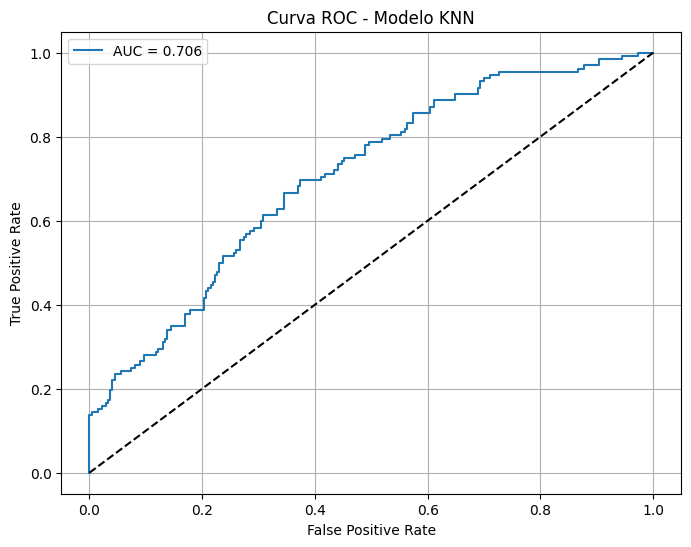

In [22]:
fpr, tpr, _ = roc_curve(y_test_final, y_proba)
auc = roc_auc_score(y_test_final, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo KNN')
plt.legend()
plt.grid()
plt.show()
